In [1]:
#necessary libs
import numpy as np 
import random 
import time
import scipy.signal as dsp
import scipy.fft as transform
import matplotlib.pyplot as plt
import cv2
import itertools
from struct import pack,unpack

In [2]:
# img1 and img2 are the 
# two input images 
img1 = cv2.imread('test.jpg') 
img2 = cv2.imread('grumpy.jpg')
# resize the coded image
img2_upscaled = cv2.resize(img2, (img1.shape[1],img1.shape[0]), interpolation = cv2.INTER_AREA)

### Metrics

In [3]:
def psnr(im1, im2):
    mse = np.mean((im1.astype(np.float64) / 255 - im2.astype(np.float64) / 255) ** 2)
    return 10 * np.log10(1. / mse)
def psnr_cv(im1, im2):
    return cv2.PSNR(im1, im2)

### LSB steganography method

In [4]:
### LSB Encryption method
# Encryption function 
def lsb_encrypt(img1, img2, k): 
    start_time = time.time()
    mask = 256 - 2**k
    stego = (img1 & mask) | (img2 >> (8 - k))            
    print("Done in ", (time.time() - start_time), "s")
    return stego
    
# Decryption function 
def lsb_decrypt(img, k): 
    start_time = time.time()
    backup = img.copy()  
    mask = 2**k - 1
    output = (backup & mask) << (8 - k)
    print("Done in ", (time.time() - start_time), "s")  
    return output

In [25]:
# Test encryption
steg = lsb_encrypt(img1,img2_upscaled, 6)

Done in  0.014514923095703125 s


In [26]:
print('PSNR: ', psnr(img1, steg), '\nCV2 PSNR: ', psnr_cv(img1, steg))

PSNR:  19.915978406719393 
CV2 PSNR:  19.915978406719393


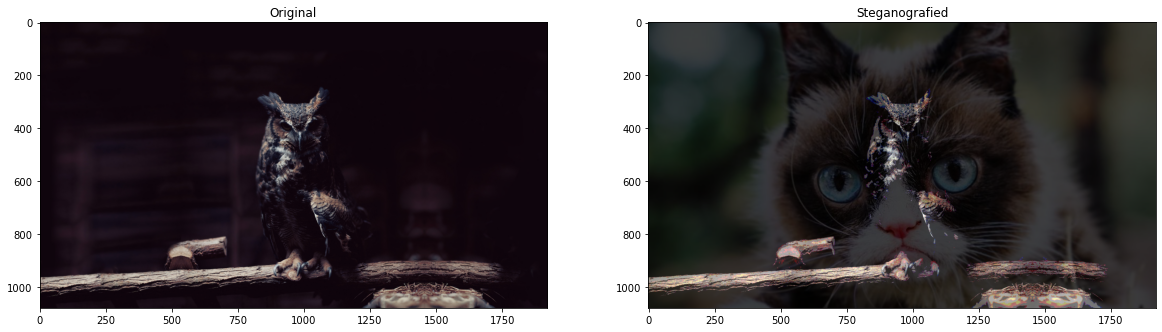

In [27]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 6))

ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax1.set_title("Original")

ax2.imshow(cv2.cvtColor(steg, cv2.COLOR_BGR2RGB))
ax2.set_title("Steganografied")

plt.show()

Done in  0.011002302169799805 s


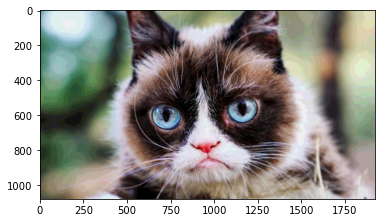

In [21]:
# Test decryption
secret = lsb_decrypt(steg, 4) 

plt.imshow(cv2.cvtColor(secret, cv2.COLOR_BGR2RGB))
plt.show()

In [22]:
print('PSNR: ', psnr(img2_upscaled, secret), '\nCV2 PSNR: ', psnr_cv(img2_upscaled, secret))

PSNR:  29.208474854448507 
CV2 PSNR:  29.20847485444851


In [29]:
#saving images
cv2.imwrite('lsb_steg.png', steg)
cv2.imwrite('lsb_extracted.png', secret)

True

In [48]:
##PVD easy
def zigZag(a, row, col): 
    evenRow = 0
    oddRow = 1
    res = []
    while evenRow < row:  
        for i in range(col): 
            res.append(a[evenRow][i])
        evenRow = evenRow + 2
        if oddRow < row: 
            for i in range(col - 1, -1, -1): 
                res.append(a[oddRow][i])
        oddRow = oddRow + 2
    return res
def access_bit(data, num):
    base = int(num // 8)
    shift = int(num % 8)
    return (data[base] & (1<<shift)) >> shift

def get_bits(data, shift, n_bits):
    res = 0
    if(shift+n_bits > len(data)*8):
        n_bits = len(data)*8-shift
    for i in range(n_bits):
        res = access_bit(data, shift+i)<<i
        #print(res, access_bit(data, shift+i))
    return res

def get_pixels(d11,d,p1,p2):
    D = d.astype(int)
    D1 = d11.astype(int)
    r = np.abs(D1 - D)
    if p1>=p2 and d11>d:
        p1 = p1+r/2
        p2 = p2-r/2
    elif p1<p2 and d11>d:
        p1 = p1-r/2
        p2 = p2+r/2
    elif p1>=p2 and d11<=d:
        p1 = p1-r/2
        p2 = p2+r/2
    elif p1<p2 and d11<=d:
        p1 = p1+r/2
        p2 = p2-r/2
    return p1,p2

def pvd(img_blocks, byte_message):
    bblocks = [img_blocks[i:i + 2] for i in range(0, len(img_blocks), 2)]
    bitcounter = 0
    for block in bblocks:
        p1 = block[0].astype(int)
        p2 = block[1].astype(int)
        d = np.abs(p1-p2)
        d_new = d
        if d <= 7:
            k = 3
            d_new += get_bits(byte_message,bitcounter,k)
            bitcounter+=k
        elif d <= 15:
            k = 3
            d_new += get_bits(byte_message,bitcounter,k)
            bitcounter+=k
        elif d <= 31:
            k = 4
            d_new += get_bits(byte_message,bitcounter,k)
            bitcounter+=k
        elif d <= 63:
            k = 5
            d_new += get_bits(byte_message,bitcounter,k)
            bitcounter+=k
        elif d <= 127:
            k = 6
            d_new += get_bits(byte_message,bitcounter,k)
            bitcounter+=k
        elif d <= 255:
            k = 7
            d_new += get_bits(byte_message,bitcounter,k)
            bitcounter+=k
        block[0],block[1] = get_pixels(d_new,d,block[0],block[1])
        if bitcounter >= len(byte_message)*8:
            break
    
    restored = np.vstack(bblocks)
    return restored

def ipvd(img_blocks):
    bblocks = [img_blocks[i:i + 2] for i in range(0, len(img_blocks), 2)]
    res = byte0b0
    for block in bblocks:
        d = np.abs(block[0]-block[1])
        L = 0
        if d <= 7:
            L = 0
        elif d <= 15:
            L = 8
        elif d <= 31:
            L = 16
        elif d <= 63:
            L = 32
        elif d <= 127:
            L = 64
        elif d <= 255:
            L = 128
        s = np.abs(d - L)
        res = res << s
    return res
### LSB Encryption method
# Encryption function 
def pvd_encrypt(cover, message): 
    # Converting string message to bytes
    if type(message) == str:
        byte_message = message.encode()
    else:
        byte_message = message
    #print(c)
    row, col = cover.shape[:2]
    img_b,img_g,img_r = cv2.split(cover)
    #img_blocks_b = zigZag(img_b, img_b.shape[0], img_b.shape[1])
    img_blocks_b = img_b.flatten()
    img_blocks_g = img_g.flatten()
    img_blocks_r = img_r.flatten()
    
    restored_b = pvd(img_blocks_b,byte_message)
    restored_g = pvd(img_blocks_g,byte_message)
    restored_r = pvd(img_blocks_r,byte_message)
    
    stego_b = np.reshape(restored_b, (row, col))
    stego_g = np.reshape(restored_g, (row, col))
    stego_r = np.reshape(restored_r, (row, col))
    
    stego = cv2.merge((stego_b,stego_g,stego_r))
    return stego
    
      
# Decryption function 
def pvd_decrypt(img): 
    img_b,img_g,img_r = cv2.split(img)
    img_blocks_b = img_b.flatten()
    img_blocks_g = img_g.flatten()
    img_blocks_r = img_r.flatten() 
    res = ipvd(img_blocks_b)
    return res

In [53]:
pvd_stego = pvd_encrypt(img1, "hello world rjgergjeojgoir geogjerogjerpjgege")

PSNR:  84.27374808612883 
CV2 PSNR:  84.2737480861287


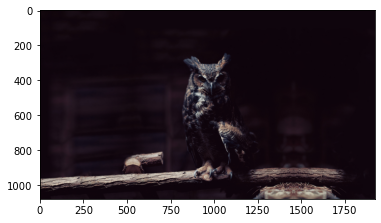

In [54]:
plt.imshow(cv2.cvtColor(pvd_stego, cv2.COLOR_BGR2RGB))
print('PSNR: ', psnr(img1, pvd_stego), '\nCV2 PSNR: ', psnr_cv(img1, pvd_stego))

In [51]:
cv2.imwrite('pvd.jpg', pvd_stego)

True

In [52]:
pvd_decrypt(pvd_stego)[:100]

UnboundLocalError: local variable 'res' referenced before assignment

### PVD (pixel value differencing) method (hard)

In [85]:
### LSB Encryption method
# Encryption function 
table2 = [[0,8,1,9],[10,2,11,3],[4,12,5,13],[14,6,15,7]]
table3 = [[1,12,8,0],[9,5,4,15],[13,6,7,11],[2,10,14,3]]
table4 = [[0,12,14,4],[11,1,5,10],[9,6,2,8],[7,13,15,3]]
table5 = [[0,11,5,10],[6,12,14,4],[1,15,13,9],[7,2,8,3]]
def embeddedLowContrast(p1,p2):
    
    return p1,p2
def apply_table(array, table):
    res = []
    for i in range(4):
        for k in table[i]:
            block2 = array[k]
            d1 = np.abs(block2[0,0]-block2[0,1])
            if d1 <= 15:
                array[k][0][0],array[k][0][1] = embeddedLowContrast(block2[0,0],block2[0,1])
            else:
                array[k][0][0],array[k][0][1] = embeddedHighContrast(block2[0,0],block2[0,1])
            d1 = np.abs(block2[1,0]-block2[1,1])
            if d1 <= 15:
                array[k][1][0],array[k][1][1] = embeddedLowContrast(block2[1,0],block2[1,1])
            else:
                array[k][1][0],array[k][1][1] = embeddedHighContrast(block2[1,0],block2[1,1])
    row = []
    for i in range(4):
        for k in range(4):
            if len(row) == 0:
                row = array[k*i+k]
            else:
                row = np.concatenate((row,array[k*i+k]),axis=1)
        if len(res) == 0:
            res = row
        else:
            res = np.concatenate((res,row),axis=0)
    return res
def tabled_shuffle(chunk, h, w):
    subblocks = [chunk[k:k+2, l:l+2] for (k,l) in itertools.product(range(0,8,2),range(0,8,2))]
    if h>w and (h*w)%2 != 0:
        return apply_table(subblocks, table2)
    if h>w and (h*w)%2 == 0:
        return apply_table(subblocks, table3)
    if h<=w and (h*w)%2 != 0:
        return apply_table(subblocks, table4)
    if h<=w and (h*w)%2 == 0:
        return apply_table(subblocks, table5)

def pvd_encrypt(cover, message): 
    # Converting string message to bytes
    if type(message) == str:
        byte_message = message.encode()
    else:
        byte_message = message
    q = 8
    j = 1
    e1 = byte_message[0]
    e2 = byte_message[1]
    c = 0.5*(e1+e2+j)*(e1+e2+j+1)+e2
    #print(c)
    row, col = cover.shape[:2]
    img_b,img_g,img_r = cv2.split(cover)
    img_blocks_b = [tabled_shuffle(img_b[j:j+8, i:i+8],j,i) for (j,i) in itertools.product(range(0,row,8),range(0,col,8))]
    img_blocks_g = [tabled_shuffle(img_g[j:j+8, i:i+8],j,i) for (j,i) in itertools.product(range(0,row,8),range(0,col,8))]
    img_blocks_r = [tabled_shuffle(img_r[j:j+8, i:i+8],j,i) for (j,i) in itertools.product(range(0,row,8),range(0,col,8))]
    for block in img_blocks_b:
        
    
    stego = 0
    return stego
    
      
# Decryption function 
def pvd_decrypt(img): 
      
    # Encrypted image 
    width = img.shape[0] 
    height = img.shape[1] 
      
    # img1 and img2 are two blank images 
    img1 = np.zeros((width, height, 3), np.uint8) 
    img2 = np.zeros((width, height, 3), np.uint8) 
      
    for i in range(width): 
        for j in range(height): 
            for l in range(3): 
                v1 = format(img[i][j][l], '08b') 
                v2 = v1[:4] + chr(random.randint(0, 1)+48) * 4
                v3 = v1[4:] + chr(random.randint(0, 1)+48) * 4
                  
                # Appending data to img1 and img2 
                img1[i][j][l]= int(v2, 2) 
                img2[i][j][l]= int(v3, 2) 
      
    return img1, img2

In [86]:
pvd_encrypt(img1, "hello world")

0

### DCT with LSB in Frequency domain

In [17]:
quant = np.array([[16,11,10,16,24,40,51,61],
                 [12,12,14,19,26,58,60,55],
                 [14,13,16,24,40,57,69,56],
                 [14,17,22,29,51,87,80,62],
                 [18,22,37,56,68,109,103,77],
                 [24,35,55,64,81,104,113,92],
                 [49,64,78,87,103,121,120,101],
                 [72,92,95,98,112,100,103,99]])

def chunks(l, n):
        m = int(n)
        for i in range(0, len(l), m):
            yield l[i:i + m]

## input - image, data to embed (gray image) 
def dct_encode(im_source, message, filename='dct_steg.png'):
    start_time = time.time()
    
    img = im_source
    row, col = img.shape[:2]    
    secret = str(len(message))+'*'
    if type(message)==str:
        print('Message passed!')
        message = message.encode()
    binary = secret.encode()+message
    #for i in range(len(binary)):
    #    print(binary[i],end= ' ')
    #print("\n")
    
    # Interpolate image up to the divisible blocks
    if row%8 != 0 or col%8 != 0:
        print('Resizing image up to: ', col+(8-col%8),row+(8-row%8))
        img = cv2.resize(img,(col+(8-col%8),row+(8-row%8)))
        row, col = img.shape[:2]
    
    # Check if the message could be potentially fitted
    print("Available capacity: ", int((row/8)*(col/8)), "bits")
    if len(message) >= ((row/8)*(col/8)):
        raise Exception("Message could not be fitted into cover image")
    
    # Split image into RGB channels
    img_b,img_g,img_r = cv2.split(img)
    img_b = np.float32(img_b)
    img_g = np.float32(img_g)
    img_r = np.float32(img_r)
    img_blocks = [img_b[j:j+8, i:i+8]-128 for (j,i) in itertools.product(range(0,row,8),range(0,col,8))]
    blocks_per_channel = len(img_blocks)
    img_blocks.extend([img_g[j:j+8, i:i+8]-128 for (j,i) in itertools.product(range(0,row,8),range(0,col,8))])
    img_blocks.extend([img_r[j:j+8, i:i+8]-128 for (j,i) in itertools.product(range(0,row,8),range(0,col,8))])
    
    # Making DCT transform
    dct_blocks = [np.round(cv2.dct(block)) for block in img_blocks]
    
    # Blocks then run through quantization table
    dct_blocks = [np.round(block/quant) for block in dct_blocks]
    
    messIndex = 0
    letterIndex = 0
        
    for i, block in enumerate(dct_blocks):
        for k in range(3):
            shift = k*blocks_per_channel
            b = dct_blocks[i+shift]
            #find LSB in DC coeff and replace with message bit
            DC = b[0][0]
            #print(DC, end=' ')
            DC = np.uint8(DC)
            DC = np.unpackbits(DC)
            #print(DC, end=' ')
            DC[7] = (binary[messIndex]>>letterIndex)&0b1
            #print((binary[messIndex]>>letterIndex)&0b1, end=' ')
            #print(DC,end= ' ')
            DC = np.packbits(DC).astype(np.int8)

            #print(DC,end= ' ')
            DC = np.float32(DC)
            #print(DC)
            b[0][0] = DC

        letterIndex = letterIndex+1
        if letterIndex == 8:
            letterIndex = 0
            messIndex = messIndex + 1
            if messIndex == len(binary):
                break
    # Inverse DCT
    inv_chunks = [block*quant for block in dct_blocks]
    inv_chunks = [cv2.idct(block)+128 for block in inv_chunks]
    
    restored=[]
    for k in range(3):
        channel=[]
        start = k*blocks_per_channel
        end = (k+1)*blocks_per_channel
        for chunkRowBlocks in chunks(inv_chunks[start:end], col/8):
            for rowBlockNum in range(8):
                for block in chunkRowBlocks:
                    channel.extend(block[rowBlockNum])
        channel = np.array(channel).reshape(row, col)
        restored.append(channel)
    
    #res = cv2.merge((restored[0],np.uint8(img_g),np.uint8(img_r)))
    res = cv2.merge((restored[0],restored[1],restored[2]))
    #res = cv2.convertScaleAbs(res)
    cv2.imwrite(filename,res)
    print("Done in ", (time.time() - start_time), "s")
    return res

def dct_decode(img, type='str'):
    start_time = time.time()
    row,col = img.shape[:2]

    messSize = None
    messageBits = bytearray()
    buff = 0

    #split image into RGB channels
    img_b,img_g,img_r = cv2.split(img)
    #print(bImg[0:16,0:16])
    #message hid in blue channel so converted to type float32 for dct function
    img_b = np.float32(img_b)
    img_g = np.float32(img_g)
    img_r = np.float32(img_r)
    
    #break into 8x8 blocks
    img_blocks = [img_b[j:j+8, i:i+8]-128 for (j,i) in itertools.product(range(0,row,8),range(0,col,8))]   
    blocks_per_channel = len(img_blocks)
    img_blocks.extend([img_g[j:j+8, i:i+8]-128 for (j,i) in itertools.product(range(0,row,8),range(0,col,8))])
    img_blocks.extend([img_r[j:j+8, i:i+8]-128 for (j,i) in itertools.product(range(0,row,8),range(0,col,8))])
    #blocks run through quantization table
    quantizedDCT = [cv2.dct(block) for block in img_blocks]
    quantizedDCT = [block/quant for block in quantizedDCT]
    
    #print(quantizedDCT[1][0])
    i=0
    #message extracted from LSB of DC coeff
    for j,quantizedBlock in enumerate(quantizedDCT):
        msg_bit_list = []
        for k in range(3):
            shift = k*blocks_per_channel
            b = quantizedDCT[j+shift]
            DC = b[0][0]
            ### Integer
            DC = np.uint8(DC)
            #print(DC, end=' ')
            DC = np.unpackbits(DC)
            if DC[7] == 1:
                msg_bit_list.extend([1])
            else: 
                msg_bit_list.extend([0])
            #print(DC)
        bit_occurences = msg_bit_list.count(1)
        if bit_occurences > 1:
            buff+= 1<<i
        i=1+i
        if i == 8:
            #print(buff, end=' ')    
            messageBits.append(buff)
            buff = 0
            i =0
            
            if chr(messageBits[-1]) == '*' and messSize is None:
                try:
                    messSize = int(messageBits[:-1].decode())
                except:
                    pass
        if len(messageBits) - len(str(messSize)) - 1 == messSize:
            print("Done in ", (time.time() - start_time), "s")
            if type == 'bin':
                return messageBits[len(str(messSize))+1:]
            return ''.join(messageBits.decode())[len(str(messSize))+1:]
    print("Done in ", (time.time() - start_time), "s")
    return ''

In [23]:
dct_img = dct_encode(img1, 'https://www.youtube.com/watch?v=AkS_KGDBh-s')

Message passed!
Available capacity:  32400 bits
Done in  5.392235040664673 s


In [24]:
dct_decode(dct_img)

Done in  0.9041934013366699 s


'https://www.youtube.com/watch?v=AkS_KGDBh-s'

In [143]:
with open('grumpy_4kB.jpg', mode='rb') as file:
    binary_file = file.read()
dct_img = dct_encode(img1, binary_file, 'dct_grumpy_4kB.png')

Available capacity:  32400 bits
Done in  5.902347087860107 s


In [144]:
sec = dct_decode(dct_img, 'bin')
print(len(sec))
f = open('dct_grumpy_4kB_restored.jpg', 'wb')
f.write(sec)
f.close()

Done in  1.483353614807129 s
3825


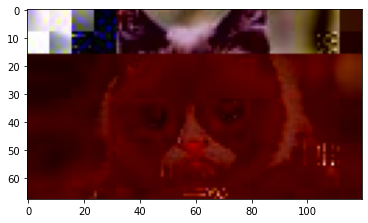

In [145]:
img_restored = cv2.imread('dct_grumpy_4kB_restored.jpg')
plt.imshow(cv2.cvtColor(cv2.convertScaleAbs(img_restored), cv2.COLOR_BGR2RGB))

In [146]:
with open('test.txt', mode='rb') as file:
    binary_file = file.read()
dct_img = dct_encode(img1, binary_file, 'dct_test_text.png')
sec = dct_decode(dct_img, 'bin')
f = open('restored.txt', 'wb')
f.write(sec)
f.close()

Available capacity:  32400 bits
Done in  5.843339681625366 s
Done in  1.413330316543579 s


PSNR:  35.88181822938096 
CV2 PSNR:  35.9127926143237


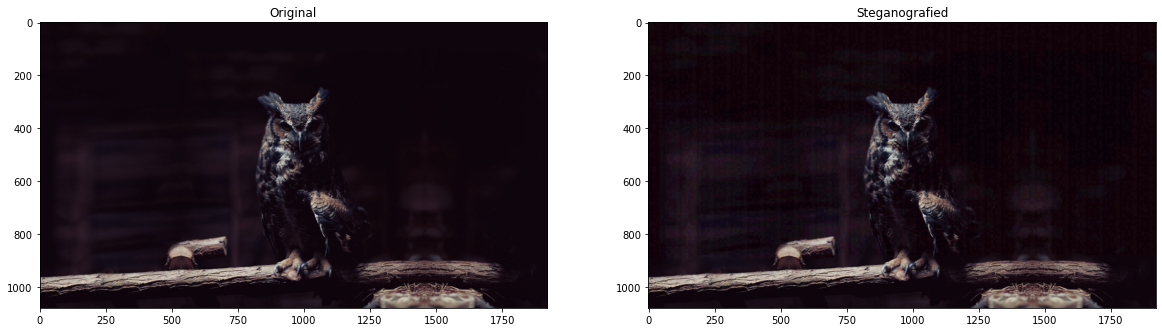

In [89]:
print('PSNR: ', psnr(img1, dct_img), '\nCV2 PSNR: ', psnr_cv(img1, cv2.convertScaleAbs(dct_img)))
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 6))

ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax1.set_title("Original")

ax2.imshow(cv2.cvtColor(cv2.convertScaleAbs(dct_img), cv2.COLOR_BGR2RGB))
ax2.set_title("Steganografied")

plt.show()

### Mixed LSB with DCT

In [109]:
import binascii

def shuffle_forward(l):
    order = list(range(len(l))) 
    np.random.shuffle(order)
    return list(np.array(l)[order]), order

def shuffle_backward(l, order):
    l_out = [0] * len(l)
    for i, j in enumerate(order):
        l_out[j] = l[i]
    return l_out

def mixed_encode(im_1,im_2):
    # randomize secrete image
    rndImg2 = im_2.copy()
    rndImg2 = np.reshape(rndImg2, (im_2.shape[0] * im_2.shape[1], im_2.shape[2]))
    rndImg2, order = shuffle_forward(rndImg2)
    rndImg2 = np.reshape(rndImg2, im_2.shape)

    #apply LSB metod
    res = lsb_encrypt(im_1, rndImg2, 4)
    #apply DCT with secret
    res = dct_encode(res, order.tobytes())
    return res

def mixed_decode(im):
    #key = dct_decode(im)
    #print(key)
    key = "10"
    im = np.around(im).astype(np.uint8)
    print(im[:12,:12, 0])
    print(im.dtype)
    res = lsb_decrypt(im, 4)
    rndImg2 = res.copy()
    rndImg2 = np.reshape(rndImg2, (im.shape[0] * im.shape[1], im.shape[2]))
    np.random.seed(binascii.crc32(key.encode()))
    rndImg2 = shuffle_backward(l_shuf, order)
    res = np.reshape(rndImg2, im.shape)
    
    return res

In [110]:
mixed = mixed_encode(img1, img2_upscaled)

AttributeError: 'list' object has no attribute 'tobytes'

PSNR:  31.886608176278802 
CV2 PSNR:  31.886608176278802


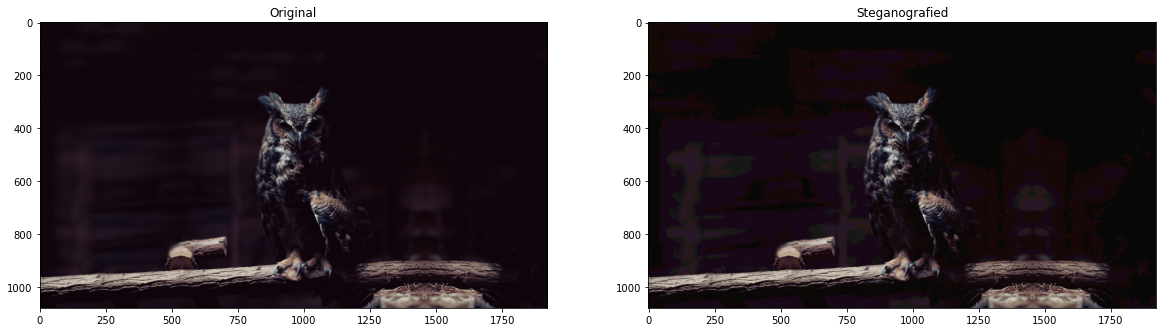

In [99]:
print('PSNR: ', psnr(img1, mixed), '\nCV2 PSNR: ', psnr_cv(img1, cv2.convertScaleAbs(mixed)))
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 6))

ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax1.set_title("Original")

ax2.imshow(cv2.cvtColor(cv2.convertScaleAbs(mixed), cv2.COLOR_BGR2RGB))
ax2.set_title("Steganografied")

plt.show()

In [100]:
restored = mixed_decode(mixed)
print('PSNR: ', psnr(img2_upscaled, restored), '\nCV2 PSNR: ', psnr_cv(img2_upscaled, restored))

[[ 5 12 15 12  2  9 10  7 10 13  6  2]
 [ 3 15 12  9  2  9  9  4 15  5 13 15]
 [ 9  9 14  5  6 11  3 10  9 15  3  9]
 [ 4  6  9 11  5 10  5  8 12 14 14 15]
 [ 6  5  9  9  2 14  6 11 12  4  3  7]
 [ 4 15 15  5  7  3  9  3  3  1 11 13]
 [ 4  1 10 14  4  6  6  2 13  4 11  8]
 [ 7  4 11 15  3  5  6 12 13  6  7  2]
 [10  4 10  4  2  1  7 15 15  9  8 15]
 [ 2  9 15  7  6 15  5  8 12 10  9  2]
 [ 1  1  9 11  4  4  7  1  3 13  8  2]
 [ 9  3  4  9  7  9  2 12 14  3  0 10]]
uint8
PSNR:  8.68882282123116 
CV2 PSNR:  8.68882282123116


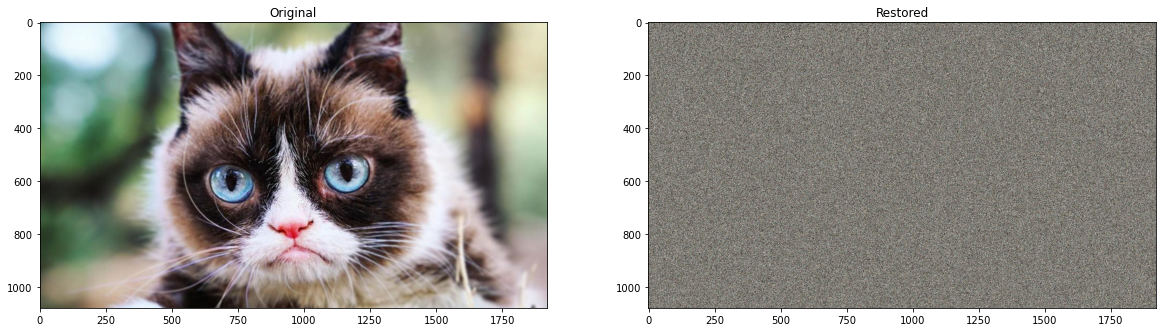

In [101]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 6))

ax1.imshow(cv2.cvtColor(img2_upscaled, cv2.COLOR_BGR2RGB))
ax1.set_title("Original")

ax2.imshow(cv2.cvtColor(restored, cv2.COLOR_BGR2RGB))
ax2.set_title("Restored")

plt.show()

In [106]:
l_shuf, order = shuffle_forward([1,9,2,3])
shuffle_backward(l_shuf, order)

[1, 9, 2, 3]

In [107]:
order

[3, 0, 2, 1]

In [108]:
l_shuf

[3, 1, 2, 9]

### Image DSP analysis

In [1]:
### DFT analysis
# DSP Library for python
import scipy.signal as dsp
import scipy.fft as transform
import matplotlib.pyplot as plt
import numpy as np 
import cv2

In [2]:
%matplotlib inline

In [3]:
test = cv2.imread('grumpy.jpg') 
# Image in BGR mode
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
test.shape

(540, 960, 3)

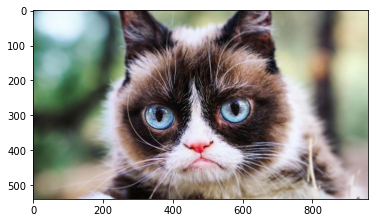

In [4]:
plt.imshow(test)

In [6]:
# Backup
cv2.imshow("test", test)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
freqs = transform.fft2(test)
freqs.shape

(540, 960, 3)

In [6]:
real = np.real(freqs)
#real = transform.fftshift(real)
real = transform.fftshift(real, axes=(0,1,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


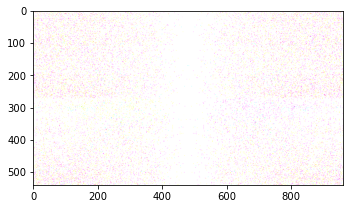

In [7]:
magnitude = 20*np.log(np.abs(real))
plt.figure(figsize=(6, 3.2))
plt.imshow(magnitude)

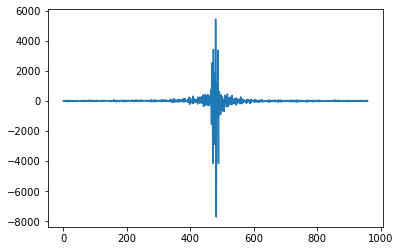

In [27]:
plt.plot(real[100,:,1])

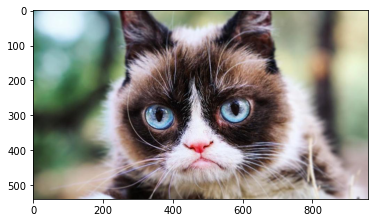

In [8]:
# Restoring image
restore = np.real(transform.ifft2(freqs))
# Converting double to 8 bits unsigned integer value
restore = restore.astype(np.uint8)
# Plotting
plt.imshow(restore)

In [9]:
(test-restore).mean()

0.2116943158436214

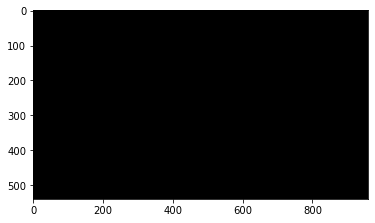

In [10]:
plt.imshow(test - restore)

In [14]:
save = cv2.cvtColor(restore, cv2.COLOR_RGB2BGR)
cv2.imwrite('ifft.jpg', save)

True

### Simple frequency domain convolve

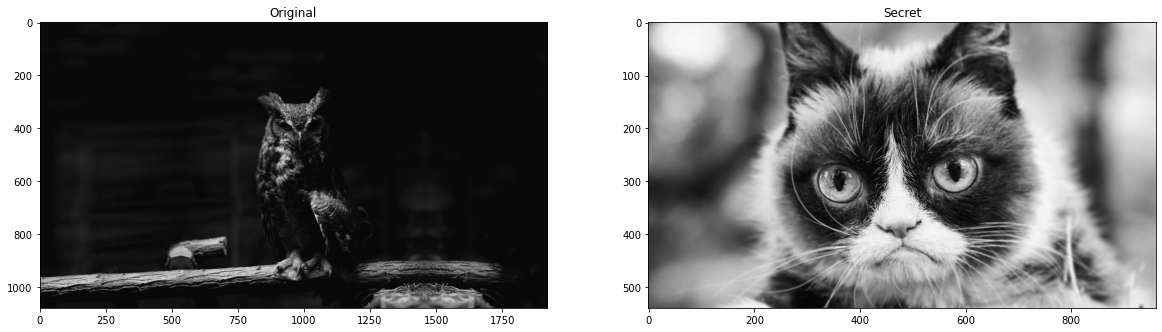

In [72]:
img1 = cv2.imread('test.jpg') 
img2 = cv2.imread('grumpy.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 6))

ax1.imshow(img1,cmap='gray')
ax1.set_title("Original")

ax2.imshow(img2,cmap='gray')
ax2.set_title("Secret")

plt.show()

In [80]:

### DFTIAT algorithm
# https://link.springer.com/content/pdf/10.1007%2F978-3-642-20998-7.pdf
# pp 336-341

def DFTIAT_GS_ENCODE(im_source, im_embed):
    image = im_source
    message = im_embed.flatten().astype(np.uint8).tobytes()
    print(len(message))
    # Checking limiting parameter
    if (len(message) >= (image.shape[0]*image.shape[1]*3/4 - 16)): 
        raise Exception("Message could not be fitted into cover image")
    
    # word counter
    c = 0
    # bit counter
    b = 0
    # Sliding 2x2 Window of cover image
    for i in range (0,(image.shape[0]-2)):
        for j in range (0,(image.shape[1]-2)):
            # Taking 2x2 window
            window = image[i:i+2,j:j+2]
            # Process Fourier Transform and take the real part
            fd = transform.fft2(window)
            r = np.real(fd).astype(int).flatten()
            # Assign LSB to embedding image bit, skipping first freq component
            ## Gathering bits 
            bits = 0
            if(c < len(message)):
                if b <= 5:
                    # we do not need to select the next word
                    bits = (message[c]>>b)&0b00000111 #Take last 3 bits with shift by bit counter
                else:
                    # selecting next word
                    residual = 8 - b
                    bits = (message[c]>>b)&(2**residual-1) # Take residual part of the current value
                    if(c < len(message)-1):
                        c += 1 # Select next byte
                        b = residual # Assign residual part for next byte
                        bits += (message[c]>>b)&0b111 # Take part of the next value
                    else:
                        break
                b += 3
            else:
                break
        if(c >= len(message)):
            break
            ##
            # Setting bits
            for k in range(0,3,1):
                r[k+1] += (bits>>k)&1  # Assigning bit to the frequency tap
            # Taking inverse transform
            chunk = np.reshape(r, (-1, 2))
            image[i:i+2,j:j+2] = np.real(transform.ifft2(chunk))
    # Converting double to 8 bits unsigned integer value
    #res = image.astype(np.uint8)
    res = image
    return res

def DFTIAT_GS_DECODE(im_coded, height, width):
    image = im_coded
    size = height*width
    sequence = []
    word = 0
    # word counter
    c = 0
    # bit counter
    b = 0
    
    # Sliding 2x2 Window of cover image
    for i in range (0,(im_coded.shape[0]-2)):
        for j in range (0,(im_coded.shape[0]-2)):
            # Taking 2x2 window
            window = image[i:i+2,j:j+2]
            # Process Fourier Transform and take the real part
            fd = transform.fft2(window)
            r = np.real(fd).astype(int).flatten()
            # Take last 3 values
            for k in range(1,4,1):
                value = r[k]
                #Take LSB from freq response
                LSB = value&1
                word = (word<<b)|LSB
                b += 1
                if b == 8:
                    b = 0
                    c += 1;
                    sequence.append(np.uint8(word))
                r[k] = value^(1<<0)
            chunk = np.reshape(r, (-1, 2))
            image[i:i+2,j:j+2] = np.real(transform.ifft2(chunk))
            #print(word, sequence)
            if (c >= size):
                break
        if (c >= size):
            break
    
    np_array = np.frombuffer(bytearray(sequence), dtype=np.uint8)
    
    h = 0
    w = 0
    print(c)
    secret = np.zeros([height, width], dtype=int)
    for i in range(0, len(np_array)):
        secret[h,w] = np_array[i]
        if w >= width - 1:
            h += 1
            w = 0
        if h >= height - 1:
            break
        w += 1
    # Converting double to 8 bits unsigned integer value
    #res = image.astype(np.uint8)
    #res = image
    return image, secret

In [81]:
x = DFTIAT_GS_ENCODE(img1,img2)

518400


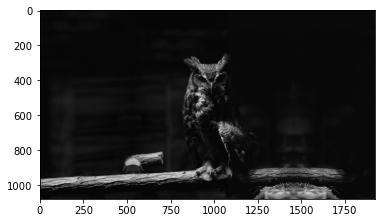

In [82]:
plt.imshow(x,cmap='gray')

In [83]:
cv2.imwrite('DFTIAT.jpg', x)

True

In [84]:
cv2.imwrite('gray.jpg', img1)

True

In [85]:
cover, secret = DFTIAT_GS_DECODE(x, img2.shape[0], img2.shape[1])

435781


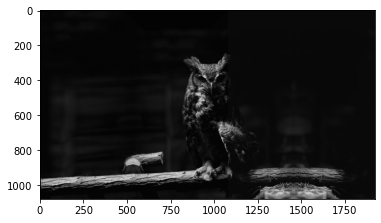

In [86]:
plt.imshow(cover,cmap='gray')

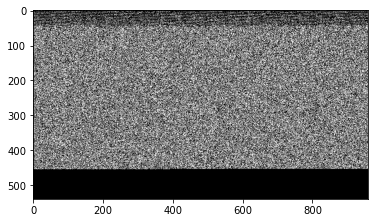

In [87]:
plt.imshow(secret,cmap='gray')

In [88]:
cv2.imwrite('DFTIAT_secret.jpg', secret)

True

In [89]:
secret

array([[  0,   0,   0, ..., 129, 128,   0],
       [  0, 129,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   1, 129,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [128]:
secret.min()

0